# Model Building: Iteration 3<br/>*Using ColumnTransformer*

### Goals
1. Use ColumnTransformer to apply different transforms to different columns.
2. Try the proposed features from the EDA notebook
3. Check if model accuracy has improved
4. Wrap IterativeImputer for use with ColumnTransformer
5. Check if model accuracy has improved

After this notebook, the only variables left untried will be Embarked and title, both of which require dummy encoding to use well.

## Pandas and Scikit Learn Workflow
A convenient workflow might be to prepare all data with Pandas and then feed the Pandas Dataframes into Scikit Learn for creating Machine Learning models.  Unfortunately Scikit Learn does not accept Pandas DataFrames as input.

As of Scikit Learn v0.20, released in September 2018, Scikit Learn can accept a Pandas DataFrame as input to a transformer and operate independently on each of the columns.  This is performed with the new ColumnTransformer.  As of v.21, released in May 2019, ColumnTransformer is no longer considered experimental. For an excellent discussion of ColumnTransformer see: [From Pandas to Scikit Learn: A New Workflow](https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62).

For an excellent discussion on working effectively with Pandas, see: [Minimally Sufficient Pandas](https://medium.com/dunder-data/minimally-sufficient-pandas-a8e67f2a2428).

Machine Learning primarily uses algorithms which make use of Linear Algebra.  Linear Algebra does not work with text or categorical values or missing values.

Although Scikit Learn's API is well above the Linear Algebra level, nevertheless the input to the Scikit Learn estimators are 2D numpy arrays of floats with no missing values.

XGBoost is an excellent algorithm which has a Scikit Learn compatible API.  This algorithm will handle null values by default, but it still requires a 2D numpy array of numbers.  XGBoost will be discussed later.  It can be installed for the Anaconda distribution by using "conda install py-xgboost".

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy:       1.16.4
pandas:      0.24.2
matplotlib:  3.1.0
seaborn:     0.9.0
sklearn:     0.21.1
Description:	Ubuntu 18.04.2 LTS


In [3]:
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

### Read Data

Add several of the extracted features proposed during EDA.

In [4]:
# Copied from titanic_helper_code.py
def get_Xy_v3(filename='./data/train.csv'):
    """Data Encoding for Iteration 3

    Version 3
    * Pclass, Fare, and Sex encoded as 1/0 for female/male
    * SibSp, Parch
    * family_size, is_cabin_notnull, is_large_family
    * is_child, is_boy, is_sibsp_zero, is_parch_zero
    """

    # read data
    all_data = pd.read_csv('./data/train.csv')
    X = all_data.drop('Survived', axis=1)
    y = all_data['Survived']

    # encode data
    X['Sex'] = X['Sex'].replace({'female':1, 'male':0})
    X['family_size'] = X['SibSp'] + X['Parch'] + 1
    X['is_cabin_notnull'] = X['Cabin'].notnull()
    X['is_large_family'] = (X['family_size'] > 4)
    X['is_sibsp_zero'] = (X['SibSp'] == 0)
    X['is_parch_zero'] = (X['Parch'] == 0)

    # comparison with null is false
    # so is_child and is_boy are false when age is null
    X['is_child'] = (X['Age'] < 18)
    X['is_boy'] = (X['Age'] < 18) & (X['Sex'] == 0)

    # drop unused fields
    drop_columns = ['PassengerId', 'Name', 
                    'Ticket', 'Embarked', 'Cabin']
    X = X.drop(drop_columns, axis=1)
    
    return X, y

In [5]:
# CV for model comparison, not model selection
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)

### Use ColumnTransformer
This will allow different preprocessing per variable.  See [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

Initially code this with SimpleImputer for Age, as that works without any additional code. Then write a wrapper around IterativeImputer for use with ColumnTransformer.

In [6]:
# Copied from titanic_helper_code.py
def get_ct_v1():
    """Column Transform for Features

    Version 1
    * without Categorical Variable Encoding
    * uses SimpleImputer for Age

    Returns column names and ColumnTransform instance.
    """
    
    # For numeric columns
    ss = StandardScaler()

    # For age imputation
    si = SimpleImputer()

    # quantize fare to below/above median
    kbin = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')

    # Pipelines
    ss_pipe = Pipeline([('ss', ss)])
    ss_si_pipe = Pipeline([('ss', ss), ('si', si)])
    kbin_pipe = Pipeline([('kbin', kbin)])

    # Columns to act on
    ss_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'family_size']
    ss_si_cols = ['Age']
    kbin_cols = ['Fare']
    bool_cols = ['Sex', 'is_cabin_notnull', 'is_large_family', 'is_child', 
                 'is_sibsp_zero', 'is_parch_zero', 'is_boy']

    transformers = [('ss_tr', ss_pipe, ss_cols),
                    ('ss_si_tr', ss_si_pipe, ss_si_cols),
                    ('kbin_tr', kbin_pipe, kbin_cols),
                    ('as_is', 'passthrough', bool_cols)]

    ct = ColumnTransformer(transformers=transformers, n_jobs=-1)

    # there is no way to know access the columns by name
    # create a list of columns to keep track
    cols = ss_cols + ss_si_cols + ['is_fare_high'] + bool_cols

    return cols, ct

In [7]:
X, y = tt.get_Xy_v3()
cols, ct = tt.get_ct_v1()

In [8]:
# examine the transformed version of X
df = pd.DataFrame(ct.fit_transform(X), columns=cols)
df.head()

,Pclass,SibSp,Parch,Fare,family_size,Age,is_fare_high,Sex,is_cabin_notnull,is_large_family,is_child,is_sibsp_zero,is_parch_zero,is_boy
0,0.827377,-0.474545,-0.473674,-0.496405,-0.560975,0.847383,0,0,False,False,False,True,True,False
1,0.827377,0.432793,0.76763,-0.240694,0.679295,-0.943705,1,0,False,False,True,False,False,True
2,0.827377,0.432793,0.76763,-0.240694,0.679295,0.365167,1,1,False,False,False,False,False,False
3,-0.369365,0.432793,-0.473674,-0.165189,0.0591599,0.0207272,1,0,False,False,False,False,True,False
4,-0.369365,0.432793,-0.473674,-0.165189,0.0591599,-0.117049,1,1,False,False,False,False,True,False


In [9]:
# use the column tranformer defined above
lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.783 max:0.849
CV Mean Score: 0.816 +/- 0.016


### Using IterativeImputer with ColumnTransformer
[IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) uses all the columns to impute missing values for all the columns.  The result is all the columns without missing values.

When a transformer is called by way of ColumnTransformer, it is only passed the columns in that transformer's column list.  For IterativeImputer to work well it needs most or all of the columns in X.  However if all the columns of X are in the transformer column list, then all the columns of X will be created as additional features.  This is too many features.

An easy way around this is to wrap the ItertiveImputer inside a custom Transformer.

In [10]:
# Copied from titanic_helper_code.py
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import TransformerMixin, BaseEstimator

class WrappedIterativeImputer(BaseEstimator, TransformerMixin):
    """Wrap IterativeImputer to return One Column Only

    The name of the column to be kept is passed to the constructor.

    This must be the first step in a pipe, as it relies on X being a 
    Pandas DataFrame"""

    def __init__(self, return_col):
        self.ii = IterativeImputer()
        self.return_col = return_col
        self.return_col_idx = None

    def fit(self, X, y):
        # fit the IterativeImputer on all the columns passed to it
        self.ii.fit(X, y)
        
        # keep track of the position of the column that will be returned
        self.return_col_idx = X.columns.get_loc(self.return_col)

        return self

    def transform(self, X):
        # transform (impute) all the missing values for X
        # return just one column of the result
        return_col = self.ii.transform(X)[:, self.return_col_idx]

        # a transformer needs to return a 2D result
        return return_col.reshape(-1, 1)

Now create a ColumnTransform similar to above.

In [11]:
# Copied from titanic_helper_code.py
def get_ct_v2():
    """Column Transform for Features

    Version 2
    * without Categorical Variable Encoding
    * uses Wrapped IterativeImputer for Age

    The IterativeImputer needs many columns in order to impute well.

    Returns column names and ColumnTransform instance.
    """

    # For numeric columns
    ss = StandardScaler()

    # Only used to impute Age
    ii = WrappedIterativeImputer('Age')

    # quantize fare to below/above median
    kbin = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')

    # Pipelines
    ss_pipe = Pipeline([('ss', ss)])

    # wrapped IterativeImputer uses many columns, but only outputs Age
    # which is then standardized
    ii_ss_pipe = Pipeline([('ii', ii), ('ss', ss)])

    # quantize Fare to below/above median
    kbin_pipe = Pipeline([('kbin', kbin)])

    # Columns to act on
    ss_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'family_size']
    ii_ss_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                  'family_size', 'is_cabin_notnull', 'is_large_family',
                  'is_child', 'is_sibsp_zero', 'is_parch_zero', 'is_boy']
    kbin_cols = ['Fare']
    bool_cols = ['Sex', 'is_cabin_notnull', 'is_large_family', 'is_child', 
                 'is_sibsp_zero', 'is_parch_zero', 'is_boy']

    transformers = [('ss_tr', ss_pipe, ss_cols),
                    ('ii_SS_tr', ii_ss_pipe, ii_ss_cols),
                    ('kbin_tr', kbin_pipe, kbin_cols),
                    ('as_is', 'passthrough', bool_cols)]

    # instantiate ColumnTransformer
    ct = ColumnTransformer(transformers=transformers)

    # there is no way to access the columns by name
    # create a list of columns to keep track
    cols = ss_cols + ['Age'] + ['is_fare_high'] + bool_cols

    return cols, ct

In [12]:
X, y = tt.get_Xy_v3()
cols, ct = tt.get_ct_v2()

# Examine the transformed X
df = pd.DataFrame(ct.fit_transform(X, y), columns=cols)

# The age values should have been imputed, so they are no longer null
print(f'Any Null Values: {df.isna().any().any()}')

df.head()

Any Null Values: False


,Pclass,SibSp,Parch,Fare,family_size,Age,is_fare_high,Sex,is_cabin_notnull,is_large_family,is_child,is_sibsp_zero,is_parch_zero,is_boy
0,0.827377,-0.474545,-0.473674,-0.496405,-0.560975,0.910831,0,0,False,False,False,True,True,False
1,0.827377,0.432793,0.76763,-0.240694,0.679295,-1.05849,1,0,False,False,True,False,False,True
2,0.827377,0.432793,0.76763,-0.240694,0.679295,0.380628,1,1,False,False,False,False,False,False
3,-0.369365,0.432793,-0.473674,-0.165189,0.0591599,0.00191201,1,0,False,False,False,False,True,False
4,-0.369365,0.432793,-0.473674,-0.165189,0.0591599,-0.149575,1,1,False,False,False,False,True,False


In [13]:
# use the column transformer defined above
lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
pipe = Pipeline([('ct', ct), ('lr', lr)])

scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.785 max:0.852
CV Mean Score: 0.819 +/- 0.017


Here, the IterativeImputer is only helping slightly, if at all.  The score went from .816 +/- 0.016 to .819.

In turns out that using the IterativeImputer will help more when it is given the dummy encoded categorical fields in the next iteration.

Continue to use the IterativeImputer.

In [14]:
# save scores for comparison with next iteration
np.save("./data/iter03.data", scores)

## Data Leakage Revisited
Fare was Discretized without looking at the Fare variable in the test data.  This avoids data leakage.  This was performed with:  
```KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')```  

The decision to descretize Fare at its median value was based on the EDA.  The EDA used only half of the available data for visualization, to help assure there was no data leakage.

**Is discretizing Age (into child/adult) at 18 years of age, data leakage?**  No, this is fine.  Domain knowledge suggests that people under the age of 18 may be treated differently. Test data is not needed to suggest this feature extraction.

**In the EDA notebook, the cutoff value of 18 years for child/adult was determined by plotting the data. Would choosing the cutoff value from a plot be data leakage?**  
Had EDA been performed on the entire data set, and there was no domain knowledge suggesting that 18 years is a special value, this could have been data leakage.  In the EDA notebook, only half the data was used for plotting to avoid this.

**What if many different values for the age cutoff for child/adult were tried in a for-loop around CV, and the best cutoff value was used?**  
This is fine for determining the best cutoff value, but it produces an estimate of model performance that is biased upward.  The test data, even though accessed via CV within a loop, is effectively used.

On the other hand, if the for-loop trying various age cutoff values was placed inside the cross validation loop, this would be fine.

**What if the experimentation was performed using cross validation until the best cutoff age was found, but the final estimate of model performance was performed against a validation set that had not previously been used?**  
This is the preferred approach when there is sufficient data.  The Titanic data set does not have enough data for this.  This is discussed in more detail on the notebook for hyperparameter optimization.

**Isn't Iterative Model Development a form of "torturing the data until it talks"?**    
If care is not taken, it could become so.

If each model iteration is about making better use of the data, for example by using additional columns that were initially unused, then this is fine.

On the other hand, if more and more extracted features are tried until the best score is achieved, this would be data leakage.  Ultimately the test set is being used over and over to find the best features to extract.  Using a final end-of-project hold-out set alleviates this problem.

### Compare Model with Previous Iteration

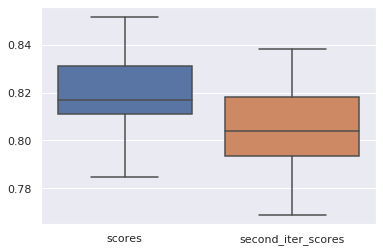

In [15]:
# Read in scores from 2nd iteration
second_iter_scores = np.load('./data/iter02.data.npy')

df = pd.DataFrame(data=list(zip(scores, second_iter_scores)),
                  columns=['scores','second_iter_scores'])
sns.boxplot(data=df)
plt.savefig(fname='3_vs_2.png', dpi=120)

The median value of one box just barely overlaps the colored box (IQR) of the other.  Arguably this is enough of a difference to consider the new model better.

At some point, it may be beneficial to start paring down the number of variables being used, but as we have not yet tried Embarked and title, it is too soon for this.

In [1]:
# previous model
print(f'Previous Cross Validated Accuracy: {second_iter_scores.mean() :.3f}')

NameError: name 'second_iter_scores' is not defined

### Notebook Summary

In this iteration we:
* used ColumnTransformer to process different variables differently
* added several variables previously suggested by EDA
* discussed some subtleties of data leakage
* compared new model with previous iteration

The model's accuracy improved from 80.4% to 81.9%